In [2]:
#8. Write a Jupyter notebook to complete the following tasks.
#a) Query raw data from Google Analytics 4 example table bigquery-public-data.ga4_obfuscated_sample_ecommerce  
# from the time range  from 2021-01-15 to  2021-01-31 (WHERE _TABLE_SUFFIX between '20210115' and  '20210131') 
# Query user_pseudo_id, number of events and total revenue per user. 
#b) Save query results to the destination BigQuery table. 
# Note that data should stay in BigQuery during the processing, don’t download a local copy! 
# The destination should be under your own project and data set, like my_project_name.G4_daily_user.G4_daily_user_data. 
# You need to create the data set in the BigQuery console
#c) Query data from the table you created. Import data to the local pandas dataframe.
#d) Visualize basic quantities, like a bar chart of revenue for the top 20 customers. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_gbq
import os

In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/tuukka/gcp_keys/atlantean-stock-385411-fce448540d0c.json"
print(os.getenv("GOOGLE_APPLICATION_CREDENTIALS"))

/home/tuukka/gcp_keys/atlantean-stock-385411-fce448540d0c.json


In [5]:
projectid = "atlantean-stock-385411"
#SQL is made completely with chatGPT and I have no idea how this UNNEST-structure works
sql = '''
SELECT
  user_pseudo_id,
  COUNT(event_name) AS event_count,
  SUM(revenue) AS total_revenue
FROM (
  SELECT
    user_pseudo_id,
    event_name,
    -- Poimitaan revenue (0 jos puuttuu)
    IFNULL(
      (
        SELECT ep.value.int_value
        FROM UNNEST(event_params) AS ep
        WHERE ep.key = 'value'
      ),
      0
    ) AS revenue
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20210115' AND '20210131'
)
GROUP BY user_pseudo_id
'''

In [6]:
from google.cloud import bigquery
client = bigquery.Client()

#define the data destination, sql defines the source
projectid = "atlantean-stock-385411"
dataset = 'data_engineering'
table_name = 'ecommerce'

destination = projectid + '.' + dataset + '.' + table_name

job_config = bigquery.QueryJobConfig(destination = destination)
job_config.write_disposition = 'WRITE_TRUNCATE'

query_job = client.query(sql,job_config = job_config)
query_job.result()
print("Query results loaded to the table {}".format(destination))

Query results loaded to the table atlantean-stock-385411.data_engineering.ecommerce


In [7]:
#projectid = "atlantean-stock-385411"

sql = f"""
SELECT *
FROM {destination}
"""

df_raw = pandas_gbq.read_gbq(sql, project_id=projectid)
print(df_raw.head())

        user_pseudo_id  event_count  total_revenue
0  82407929.8491884922            1              0
1  81651824.8602369227            1              0
2   8316563.5018635720            1              0
3  16449162.6335677259            1              0
4   5127315.2341705680            1              0


/home/tuukka/data_engineering/venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:2689: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


In [14]:
df_top20 = df_raw.sort_values(by=['total_revenue'], ascending = False).head(20)

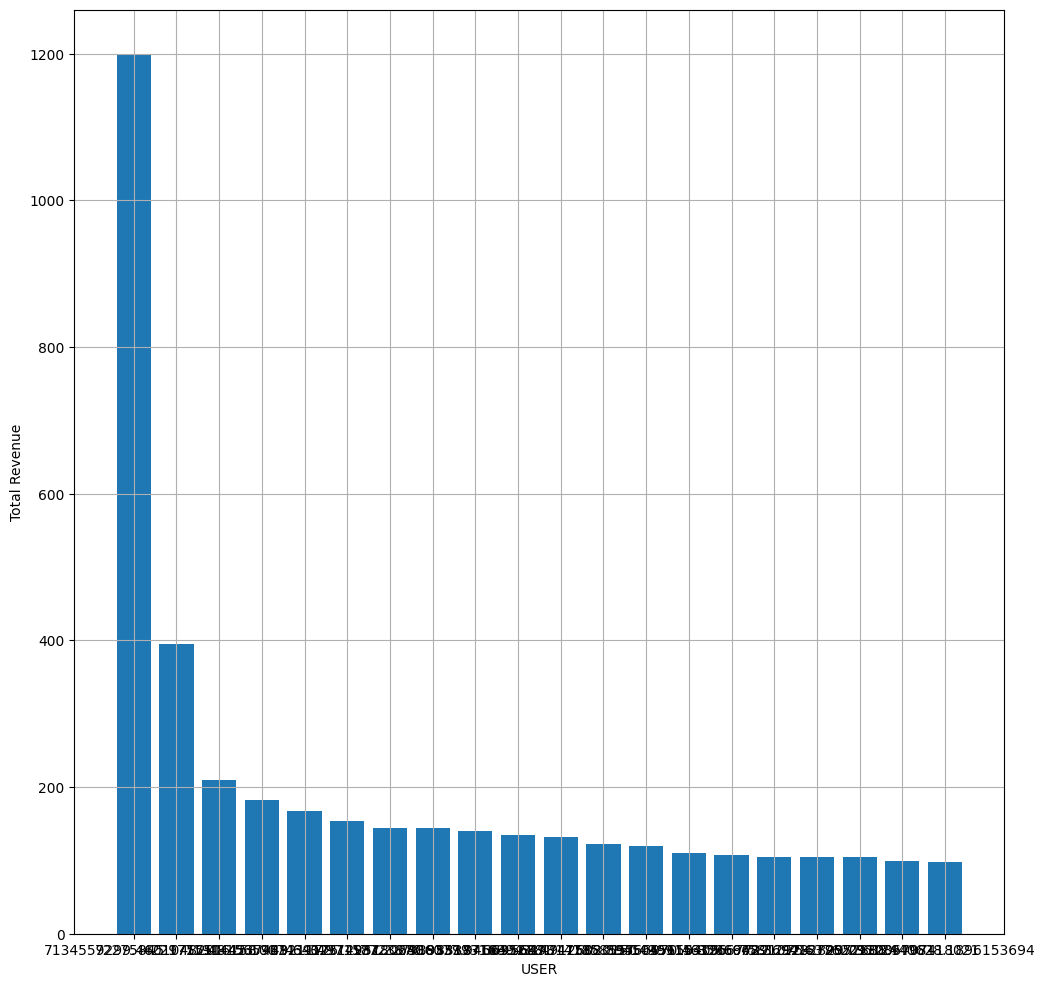

In [22]:
plt.figure(figsize = (12,12))
plt.bar(df_top20['user_pseudo_id'], df_top20['total_revenue'])
plt.xlabel("USER")
plt.ylabel("Total Revenue")
plt.grid()
plt.show()